In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
%env PYTHONHASHSEED=0

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session

# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

env: PYTHONHASHSEED=0



## Import Necessary Packages

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, Conv1DTranspose, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ReLU, Masking, Concatenate, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Zeros
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.python.keras import regularizers

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import lime.lime_tabular

import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Load Datasets

In [7]:
meta = pd.read_csv("Data/cdiff_meta_COMBINED.txt", sep = "\t")

#bacterial datasets
bacteria = pd.read_csv("Data/filtered_species_table-NEW.txt", sep = "\t")
bacteria_species = pd.read_csv("Data\ALL-SPECIES-species-ed_lefse_CDIStatus-k2-full.txt.2.txt", sep = "\t")

#fungal datasets
fungi = pd.read_csv("Data/filtered_species_table-FUNGI.txt", sep = "\t")
fungi_species = pd.read_csv("Data/FUNGI-SPECIES-species-lefse_CDIStatus-k2-fungi.txt.2.txt", sep = "\t")
fungi_genes = pd.read_csv("Data/FUNGI-GENES-ed_renamed_lefse_CDIStatus-genes-emapper-fungi.txt.2.txt", sep = "\t")
full_fungi = pd.read_csv("Data/taxa-expression-profile-FUNGI.txt", sep = "\t")

#combined datasets
combined = pd.read_csv("Data/table-hits-combined.txt", sep = "\t")
combined_genes = pd.read_csv("Data/ALL-GENES-renamed_lefse_CDIStatus-emapper-full.txt", sep = "\t")

## Fungi Preprocessing

In [8]:
# change name separator from . to ;
fungi_species_name = []
for species in fungi_species["Species"]:
    species = species.split('.')
    species = ';'.join(species)
    fungi_species_name.append(species)

In [9]:
# transpose fungi data
fungi = fungi.set_index("SampleID")
fungi = fungi.transpose()
fungi.index = fungi.index.map(int)

In [10]:
# subset data with lefse selected species
fungi = fungi[fungi_species_name]

In [11]:
# sort by index
fungi = fungi.sort_index()

In [12]:
## Process full fungi data

In [13]:
# transpose fungi data
full_fungi = full_fungi.set_index("SampleID")
full_fungi = full_fungi.transpose()
full_fungi.index = full_fungi.index.map(int)

In [14]:
# subset data w/ lefse selected genes
full_fungi = full_fungi[fungi_genes["GeneID"]]
full_fungi.shape

(39, 52)

In [15]:
full_fungi = full_fungi.sort_index()
full_fungi_names = full_fungi.columns

## Bacteria Preprocessing

In [16]:
#change all name separators to '_'
bacteria_species_names = []
for name in bacteria_species["Species"]:
    name = re.sub("[^0-9a-zA-Z]+", "_", name)
    bacteria_species_names.append(name)

In [17]:
# transpose bacteria data
bacteria = bacteria.set_index("SampleID")
bacteria = bacteria.transpose()

In [18]:
# get sample indexes
sample_ids = list(bacteria.index)

In [19]:
# sort by index
bacteria.index = bacteria.index.map(int)
bacteria = bacteria.sort_index()

In [20]:
#change all name separators to '_'
new_col_names = []
for name in bacteria.columns:
    name = re.sub("[^0-9a-zA-Z]+", "_", name)
    new_col_names.append(name)
    
bacteria.columns = new_col_names

In [21]:
# subset with lefse selected species names
bacteria = bacteria[bacteria_species_names]

In [22]:
bacteria.shape

(39, 222)

In [23]:
# transpose combined data
combined = combined.set_index("SampleID")
combined = combined.transpose()
combined.index = combined.index.map(int)

In [24]:
# subset with lefse selected genes
combined = combined[combined_genes["GeneID"]]
combined.shape

(39, 130)

In [25]:
combined = combined.sort_index()
combined_names = combined.columns

In [26]:
meta = meta[meta["SampleID"].isin(sample_ids)]

In [27]:
# make output vector (positive/negative) from metadata
y = [1 if i == 'Positive' else 0 for i in meta["CDIStatus"]]
y = np.array(y)
y = y.astype("float32")

In [28]:
#convert to numpy array
fungi = np.array(fungi)
fungi = fungi.astype("float32")

full_fungi = np.array(full_fungi)
full_fungi = full_fungi.astype("float32")

combined = np.array(combined)
combined = combined.astype("float32")

bacteria = np.array(bacteria)
bacteria = bacteria.astype("float32")

## Fungi Species Testing

Scores for each fold are: [0.75       0.75       1.         1.         1.         0.5
 0.5        0.75       0.5        1.         0.5        0.75
 1.         0.5        1.         0.5        1.         1.
 0.5        1.         1.         0.75       0.75       1.
 0.5        0.75       0.5        1.         0.75       0.66666667
 0.75       0.5        1.         0.5        1.         0.5
 0.5        1.         0.75       0.33333333 1.         0.75
 1.         0.25       0.75       1.         0.75       0.75
 0.75       0.66666667]
Average score: 0.753 (+/-0.218)


<AxesSubplot:>

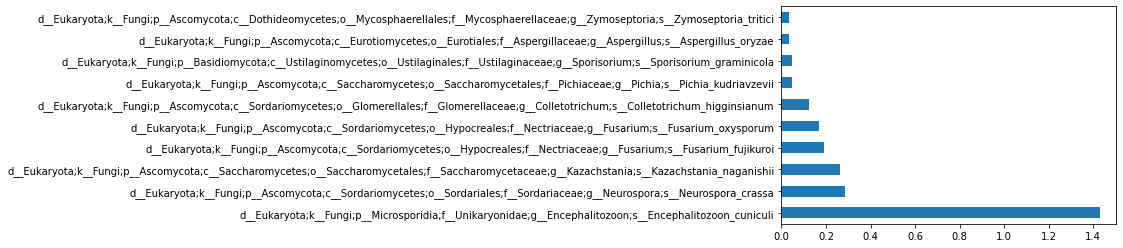

In [29]:
# Linear SVM
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt

clf = svm.SVC(kernel = 'linear', C = 1)
clf.fit(fungi, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
score = cross_val_score(clf, fungi, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.coef_[0]), index=fungi_species_name).nlargest(10).plot(kind='barh')


<AxesSubplot:>

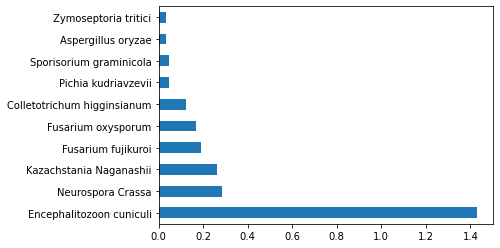

In [30]:
## SVM Viz.
svm_names = ['Encephalitozoon cuniculi',
             'Neurospora Crassa',
             'Kazachstania Naganashii',
             'Fusarium fujikuroi',
             'Fusarium oxysporum',
             'Colletotrichum higginsianum',
             'Pichia kudriavzevii',
             'Sporisorium graminicola',
             'Aspergillus oryzae',
             'Zymoseptoria tritici']

svm_feats = pd.Series(abs(clf.coef_[0]), index=fungi_species_name).nlargest(10)
svm_feats.set_axis(svm_names).plot(kind='barh')

Scores for each fold are: [0.25       1.         0.75       0.75       0.5        0.5
 0.5        0.5        0.75       0.66666667 0.5        1.
 0.75       0.5        0.5        0.25       0.25       0.75
 0.5        1.         0.25       0.5        0.75       0.75
 0.5        0.5        0.75       0.75       1.         0.66666667
 1.         0.25       0.5        0.5        0.25       1.
 0.5        1.         0.75       0.66666667 0.25       0.75
 0.         0.5        0.75       0.75       1.         0.75
 0.25       0.33333333]
Average score: 0.607


<AxesSubplot:>

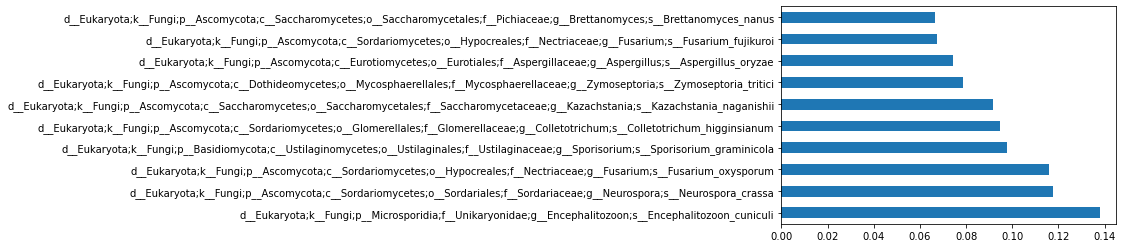

In [28]:
# Random Forest 
clf = RandomForestClassifier()
clf.fit(fungi, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
score = cross_val_score(clf, fungi, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=fungi_species_name).nlargest(10).plot(kind='barh')

In [131]:
# Now with cross-validation
# Begin K-fold Cross-Validation
kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(fungi, y):
    
    model = Sequential([
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    
    model.fit(fungi[train], y[train],
              epochs = 1000,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(fungi[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} ".format(model.metrics_names[1], train_result[1]))
    
    result = model.evaluate(fungi[test], y[test], verbose = 0)
    print("{:s}: {:.2%} \n".format(model.metrics_names[1], result[1]))
    
    cvacc.append(result[1])
    
print("Accuracy: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc)))

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 88.57% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 91.43% 
accuracy: 100.00% 

train accuracy: 88.57% 
accuracy: 25.00% 

train accuracy: 85.71% 
accuracy: 50.00% 

train accuracy: 94.29% 
accuracy: 50.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 91.67% 
accuracy: 33.33% 

train accuracy: 94.29% 
accuracy: 50.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 100.00% 

train accuracy: 91.43% 
accuracy: 100.00% 

train accuracy: 91.43% 
accuracy: 25.00% 

train accuracy: 85.71% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 85.71% 
accuracy: 75.00% 

train accuracy: 91.67% 
accuracy: 100.00% 

train accuracy: 91.43% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train

## Fungi Gene Testing

Scores for each fold are: [0.5        0.5        0.5        0.5        0.5        0.5
 0.75       0.         0.75       0.66666667 0.75       0.5
 0.5        0.25       0.75       1.         0.5        0.25
 0.5        0.66666667 0.5        0.25       0.75       0.75
 0.75       0.75       0.25       0.5        0.75       0.33333333
 0.5        0.         0.5        0.5        0.5        0.75
 1.         0.5        0.5        0.66666667 0.         0.5
 0.75       0.5        0.75       0.5        0.5        0.75
 1.         0.33333333]
Average score: 0.548 (+/-0.227)


<AxesSubplot:ylabel='SampleID'>

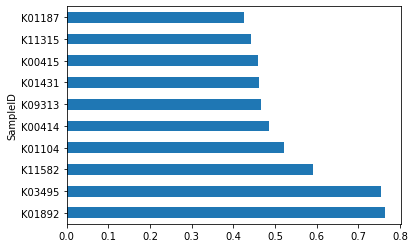

In [36]:
# Linear SVM
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt

clf = svm.SVC(kernel = 'linear', C = 1)
clf.fit(full_fungi, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
score = cross_val_score(clf, full_fungi, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.coef_[0]), index=full_fungi_names).nlargest(10).plot(kind='barh')


Scores for each fold are: [0.5        0.5        0.75       1.         0.5        1.
 1.         0.25       0.75       0.66666667 1.         0.5
 0.75       0.5        0.75       0.75       0.75       0.25
 0.75       0.66666667 0.75       0.25       0.75       1.
 1.         1.         0.5        0.75       0.25       0.33333333
 0.5        0.25       0.5        1.         0.25       0.75
 1.         0.75       0.5        1.         0.25       1.
 0.75       0.75       0.25       0.75       0.25       0.75
 1.         0.66666667]
Average score: 0.662


<AxesSubplot:ylabel='SampleID'>

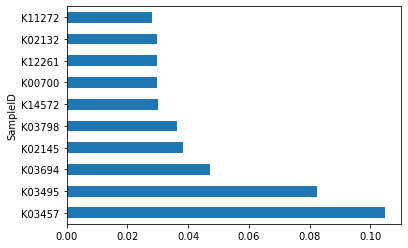

In [124]:
# Random Forest 
clf = RandomForestClassifier()
clf.fit(full_fungi, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
score = cross_val_score(clf, full_fungi, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=full_fungi_names).nlargest(10).plot(kind='barh')

In [132]:
# Now with cross-validation
# Begin K-fold Cross-Validation
kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(full_fungi, y):
    
    model = Sequential([
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    
    model.fit(full_fungi[train], y[train],
              epochs = 1000,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(full_fungi[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} ".format(model.metrics_names[1], train_result[1]))
    
    result = model.evaluate(full_fungi[test], y[test], verbose = 0)
    print("{:s}: {:.2%} \n".format(model.metrics_names[1], result[1]))
    
    cvacc.append(result[1])
    
print("Accuracy: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc)))

train accuracy: 80.00% 
accuracy: 100.00% 

train accuracy: 82.86% 
accuracy: 50.00% 

train accuracy: 82.86% 
accuracy: 50.00% 

train accuracy: 80.00% 
accuracy: 50.00% 

train accuracy: 82.86% 
accuracy: 25.00% 

train accuracy: 80.00% 
accuracy: 100.00% 

train accuracy: 77.14% 
accuracy: 75.00% 

train accuracy: 77.14% 
accuracy: 50.00% 

train accuracy: 80.00% 
accuracy: 75.00% 

train accuracy: 80.56% 
accuracy: 66.67% 

train accuracy: 82.86% 
accuracy: 50.00% 

train accuracy: 80.00% 
accuracy: 50.00% 

train accuracy: 82.86% 
accuracy: 50.00% 

train accuracy: 82.86% 
accuracy: 50.00% 

train accuracy: 80.00% 
accuracy: 50.00% 

train accuracy: 77.14% 
accuracy: 100.00% 

train accuracy: 74.29% 
accuracy: 75.00% 

train accuracy: 80.00% 
accuracy: 50.00% 

train accuracy: 85.71% 
accuracy: 50.00% 

train accuracy: 77.78% 
accuracy: 100.00% 

train accuracy: 82.86% 
accuracy: 50.00% 

train accuracy: 82.86% 
accuracy: 25.00% 

train accuracy: 85.71% 
accuracy: 50.00% 

train a

## Bacteria Species Testing

Scores for each fold are: [1.         1.         1.         0.75       0.75       1.
 0.5        1.         0.75       0.66666667 1.         0.75
 0.75       1.         0.75       0.75       0.75       1.
 0.5        1.         1.         1.         0.75       1.
 0.25       1.         1.         1.         1.         0.33333333
 0.75       1.         0.75       1.         1.         0.5
 1.         1.         0.75       1.         0.75       1.
 1.         0.75       0.75       1.         1.         0.5
 1.         0.66666667]
Average score: 0.843 (+/-0.197)


<AxesSubplot:>

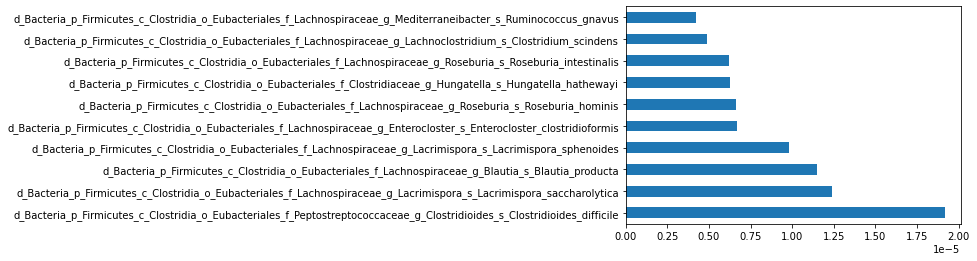

In [29]:
# Linear SVM
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt

clf = svm.SVC(kernel = 'linear', C = 1)
clf.fit(bacteria, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
score = cross_val_score(clf, bacteria, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.coef_[0]), index=bacteria_species_names).nlargest(10).plot(kind='barh')


Scores for each fold are: [1.         0.75       0.75       0.75       0.75       1.
 0.75       0.75       0.75       0.33333333 1.         0.5
 1.         1.         0.75       0.75       0.75       0.75
 0.75       1.         1.         0.5        0.75       1.
 0.5        0.75       0.75       1.         1.         0.66666667
 0.75       1.         0.5        1.         0.5        0.5
 1.         1.         0.75       0.66666667 1.         0.75
 1.         1.         0.75       0.75       0.75       0.5
 0.75       0.66666667]
Average score: 0.787


<AxesSubplot:>

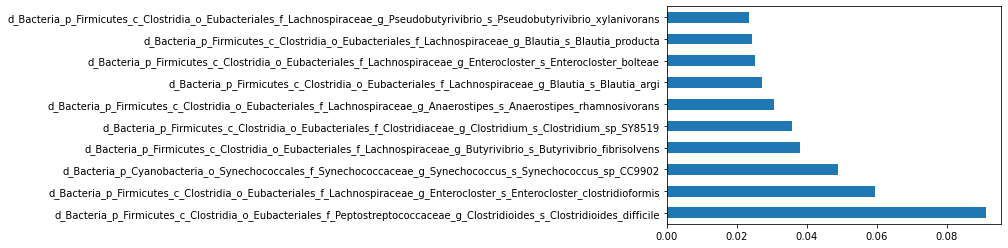

In [127]:
# Random Forest 
clf = RandomForestClassifier()
clf.fit(bacteria, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
score = cross_val_score(clf, bacteria, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f}".format(score.mean())}')

pd.Series(abs(clf.feature_importances_), index=bacteria_species_names).nlargest(10).plot(kind='barh')

In [130]:
# Now with cross-validation
# Begin K-fold Cross-Validation
kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(bacteria, y):
    
    model = Sequential([
        Lambda(lambda x: K.log(K.cast((1 + x * 1000), "float32"))/K.log(K.cast((1 + 1000), "float32"))),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    
    model.fit(bacteria[train], y[train],
              epochs = 1000,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(bacteria[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} ".format(model.metrics_names[1], train_result[1]))
    
    result = model.evaluate(bacteria[test], y[test], verbose = 0)
    print("{:s}: {:.2%} \n".format(model.metrics_names[1], result[1]))
    
    cvacc.append(result[1])
    
print("Accuracy: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc)))

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 25.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 100.00% 
accuracy: 50.00% 

train accuracy: 94.44% 
accuracy: 66.67% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 94.29% 
accuracy: 50.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 100.00% 
accuracy: 50.00% 

train accuracy: 91.67% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.

## Combined Gene Testing

Scores for each fold are: [1.         0.75       0.5        1.         1.         0.75
 0.         0.75       0.5        0.66666667 0.5        0.5
 0.75       0.5        0.5        0.75       1.         0.75
 0.5        0.66666667 0.5        0.75       0.75       0.5
 0.25       0.75       1.         0.75       0.75       0.66666667
 0.75       0.5        0.75       0.75       0.75       0.75
 0.75       0.75       0.5        0.66666667 0.5        0.5
 1.         0.75       0.75       0.5        0.75       0.5
 0.5        1.        ]
Average score: 0.673 (+/-0.199)


<AxesSubplot:ylabel='SampleID'>

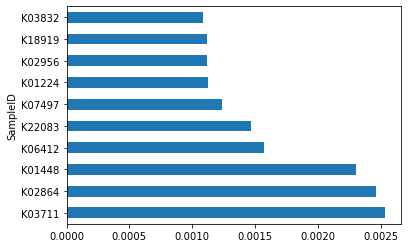

In [275]:
# Linear SVM
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt

clf = svm.SVC(kernel = 'linear', C = 2)
clf.fit(combined, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)
score = cross_val_score(clf, combined, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.coef_[0]), index=combined_names).nlargest(10).plot(kind='barh')


Scores for each fold are: [0.75       1.         0.5        1.         1.         1.
 0.75       0.5        0.75       0.33333333 1.         0.75
 0.75       0.75       1.         0.75       1.         1.
 1.         0.66666667 1.         0.75       0.75       0.75
 0.75       0.75       1.         0.75       0.75       1.
 1.         0.75       0.75       0.75       1.         1.
 1.         1.         0.5        0.66666667 1.         1.
 0.75       1.         0.5        1.         0.75       1.
 0.5        1.        ]
Average score: 0.828 (+/-0.181)


<AxesSubplot:ylabel='SampleID'>

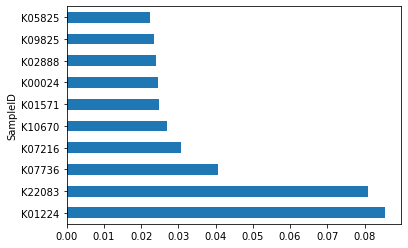

In [ ]:
# Random Forest 
clf = RandomForestClassifier()
clf.fit(combined, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
score = cross_val_score(clf, combined, y, scoring='accuracy', cv=cv)

# report performance
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.3f} (+/-{:.3f})".format(score.mean(), score.std())}')

pd.Series(abs(clf.feature_importances_), index=combined_names).nlargest(10).plot(kind='barh')

In [296]:
# Now with cross-validation
# Begin K-fold Cross-Validation
kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
cvacc = []
cvauc = []

# create model with CV compatibility
for train, test in kfold.split(combined, y):
    
    model = Sequential([
        Lambda(lambda x: K.log(K.cast((1 + x * 1000), "float32"))/K.log(K.cast((1 + 1000), "float32"))),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(500, activation = 'softplus', kernel_regularizer=tf.keras.regularizers.l1(.001)),
        Dropout(.4),
        BatchNormalization(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = "Adam",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    
    model.fit(combined[train], y[train],
              epochs = 1000,
              validation_split = .2,
              verbose = 0)
    
    train_result = model.evaluate(combined[train], y[train], verbose = 0)
    print("train {:s}: {:.2%} ".format(model.metrics_names[1], train_result[1]))
    
    result = model.evaluate(combined[test], y[test], verbose = 0)
    print("{:s}: {:.2%} \n".format(model.metrics_names[1], result[1]))
    
    cvacc.append(result[1])
    
print("Accuracy: {:.2%} (+/-{:.2%})".format(np.mean(cvacc), np.std(cvacc)))

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 50.00% 

train accuracy: 100.00% 
accuracy: 100.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 50.00% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.22% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 100.00% 
accuracy: 75.00% 

train accuracy: 94.29% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 100.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.22% 
accuracy: 66.67% 

train accuracy: 94.29% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 75.00% 

train accuracy: 97.14% 
accuracy: 100.00% 